In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
from src.modeling import MammoDataset
from src.utils import SPLIT_TRAIN_DIR, SPLIT_TEST_DIR
from torchvision import transforms

import matplotlib.pyplot as plt

import random

In [37]:
train_transform = transforms.Compose([
    transforms.ToTensor()
])

In [38]:
train_ds = MammoDataset(SPLIT_TRAIN_DIR, extension='png', transform=train_transform)
test_ds = MammoDataset(SPLIT_TEST_DIR, extension='png', transform=train_transform)

Found 2390 images for 4 classes.
Found 598 images for 4 classes.


In [39]:
train_ds.get_image_count_per_class()

{'luminal-b': 1200,
 'luminal-a': 482,
 'her2-enriched': 432,
 'triple-negative': 276}

In [40]:
test_ds.get_image_count_per_class()

{'luminal-b': 300,
 'luminal-a': 124,
 'her2-enriched': 106,
 'triple-negative': 68}

In [41]:
def plot_random_images(dataset, n=5):
    fig, axes = plt.subplots(1, n, figsize=(15, 3))
    for i in range(n):
        idx = random.randint(0, len(dataset) - 1)
        img, label = dataset[idx]
        axes[i].imshow(img.permute(1, 2, 0), cmap='gray')
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    plt.show()

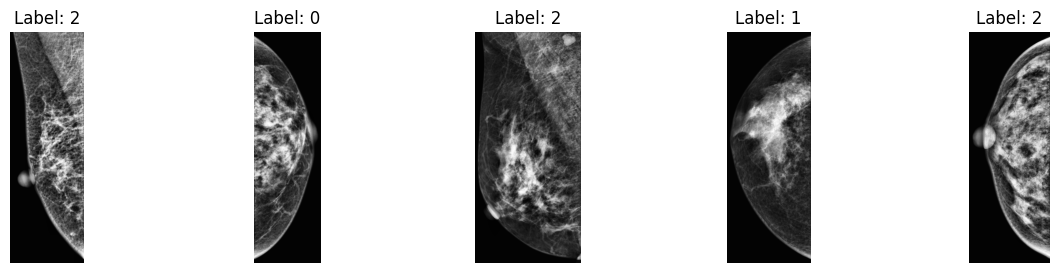

In [42]:
plot_random_images(train_ds )